## Train GPT Model on JSON data


In [1]:
# Imports and Setup
import torch
from transformers import GPT2LMHeadModel, AutoConfig, TrainingArguments, Trainer, DataCollatorForLanguageModeling
import psutil
import gc
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Check if MPS is available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from docformer.data import (
    DocPermuterPipe,
    DocTokenizerPipe,
    PadTruncTokensPipe,
    SchemaParserPipe,
    TargetFieldPipe,
    TokenEncoderPipe,
    UpscalerPipe,
    load_df_from_mongodb,
)

# load data into dataframe and split into train/test
# df = load_df_from_mongodb("mongodb://localhost:27017", "codenet", "train", projection={"_id": 0, "filePath": 0})
# df = load_df_from_mongodb("mongodb://localhost:27017", "openml", "1590-adult", projection={"_id": 0, "fnlwgt": 0})
df = load_df_from_mongodb("mongodb://localhost:27017", "openml", "23-cmc", projection={"_id": 0})
train_docs_df, test_docs_df = train_test_split(df, test_size=0.2, shuffle=True)

TARGET_FIELD = "target"

# create train and test pipelines
pipes = {
    # --- train only ---
    "schema": SchemaParserPipe(),
    "upscaler": UpscalerPipe(n=400),
    "permuter": DocPermuterPipe(),
    # --- test only ---
    "target": TargetFieldPipe(TARGET_FIELD),
    # --- train and test ---
    "tokenizer": DocTokenizerPipe(),
    "padding": PadTruncTokensPipe(length="max"),
    "encoder": TokenEncoderPipe(),
}

train_pipeline = Pipeline(
    [(name, pipes[name]) for name in ("target", "upscaler", "permuter", "tokenizer", "padding", "encoder")]
)
test_pipeline = Pipeline([(name, pipes[name]) for name in ("target", "tokenizer", "padding", "encoder")])

# process train, eval and test data
train_df = train_pipeline.fit_transform(train_docs_df)
test_df = test_pipeline.transform(test_docs_df)

# allow transitions in vpda to work for test data
# pipes["schema"].fit(test_docs_df)

# get stateful objects
# schema = pipes["schema"].schema
encoder = pipes["encoder"].encoder
block_size = pipes["padding"].length

# print data stats
print(f"len train: {len(train_df)}, len test: {len(test_df)}")
print(f"vocab size {encoder.vocab_size}")
print(f"block size {block_size}")

len train: 471200, len test: 295
vocab size 73
block size 23


In [25]:
from datasets import Dataset
from docformer.utils import Symbol

# Create custom config
config = AutoConfig.from_pretrained(
    "gpt2",
    vocab_size=encoder.vocab_size,
    n_ctx=block_size,
    bos_token_id=encoder.encode(Symbol.START),
    eos_token_id=encoder.encode(Symbol.END),
    pad_token_id=encoder.encode(Symbol.PAD),
    hidden_size=128, 
    num_attention_heads=4,
    num_hidden_layers=4,
)

model = GPT2LMHeadModel(config).to(device)
model.resize_token_embeddings(encoder.vocab_size)

Embedding(73, 128)

In [26]:
# prepare HuggingFace Dataset
train_df["input_ids"] = train_df["tokens"]
test_df["input_ids"] = test_df["tokens"]

train_df.drop(columns=["tokens", "docs", "id"], inplace=True)
test_df.drop(columns=["tokens", "docs", "id"], inplace=True)

# create HuggingFace datasets from Pandas DataFrames
train_tokenized = Dataset.from_pandas(train_df)
test_tokenized = Dataset.from_pandas(test_df)

# # set format to Torch
train_tokenized.set_format("torch", columns=["input_ids"])
test_tokenized.set_format("torch", columns=["input_ids"])


train_tokenized


Dataset({
    features: ['target', 'ordered_docs', 'input_ids'],
    num_rows: 471200
})

In [27]:
from transformers import AutoTokenizer

dummy_tokenizer = AutoTokenizer.from_pretrained("gpt2")
dummy_tokenizer._pad_token = "<PAD>"
dummy_tokenizer.pad_token_id = encoder.encode(Symbol.PAD)
dummy_tokenizer.padding_side = "right"


In [28]:
from transformers import TrainerCallback

class LossCallback(TrainerCallback):
    def __init__(self):
        self.training_loss = []
        self.step = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if state.is_local_process_zero and 'loss' in logs:
            self.training_loss.append(logs['loss'])
            self.step.append(state.global_step)
            self.plot_loss()

    def plot_loss(self):
        clear_output(wait=True)
        plt.figure(figsize=(12, 6))
        plt.plot(self.step, self.training_loss)
        plt.title('Training Loss Curve')
        plt.xlabel('Step')
        plt.ylabel('Loss')
        plt.show()

    # Implement other required methods as no-ops
    def on_init_end(self, args, state, control, **kwargs):
        pass

    def on_train_begin(self, args, state, control, **kwargs):
        pass

    def on_train_end(self, args, state, control, **kwargs):
        pass

loss_callback = LossCallback()

In [29]:

# Set up training arguments
training_args = TrainingArguments(
    output_dir="./checkpoints",
    num_train_epochs=4,
    per_device_train_batch_size=100,
    warmup_steps=500,
    weight_decay=0.01,
    learning_rate=5e-4,
    logging_dir='./logs',
    logging_steps=100,
    report_to="none",  # Disable wandb logging
)

data_collator = DataCollatorForLanguageModeling(tokenizer=dummy_tokenizer, mlm=False)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    data_collator=data_collator,
    callbacks=[loss_callback]
)


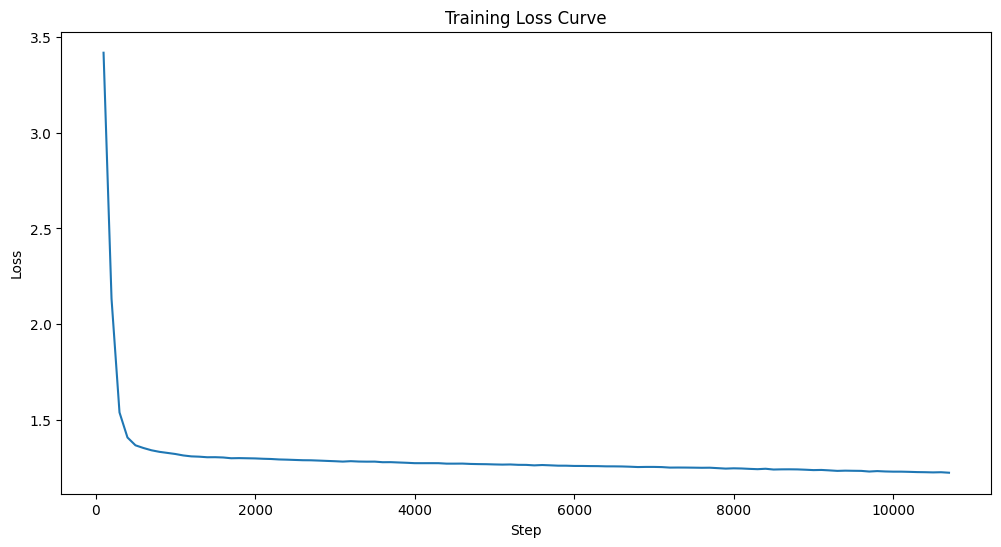

{'loss': 1.2243, 'grad_norm': 0.4558846950531006, 'learning_rate': 0.00022204054937867887, 'epoch': 2.27}


In [30]:

# Train model
print("Starting training...")
trainer.train()
print("Training completed!")
loss_callback.plot_loss()


In [10]:

# Save the model
model.save_pretrained("./checkpoints/checkpoint-final")
print("Model saved!")

Model saved!


## Evaluation


In [21]:
from transformers import Trainer, TrainingArguments
import numpy as np
import torch

# Set up evaluation arguments
eval_args = TrainingArguments(
    output_dir="./checkpoints",
    do_train=False,
    do_eval=True,
    per_device_eval_batch_size=32,
    dataloader_drop_last=False
)

# Create a Trainer instance for evaluation
eval_trainer = Trainer(
    model=model,
    args=eval_args,
    eval_dataset=test_tokenized,
    data_collator=data_collator
)

# Run evaluation
eval_results = eval_trainer.evaluate()

# Print evaluation results
print("Evaluation Results:")
for key, value in eval_results.items():
    print(f"{key}: {value}")

# Calculate perplexity
perplexity = np.exp(eval_results['eval_loss'])
print(f"Perplexity: {perplexity}")

# Generate some text as a sanity check
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)
_ = model.eval()


  0%|          | 0/10 [00:00<?, ?it/s]

Evaluation Results:
eval_loss: 1.3296754360198975
eval_model_preparation_time: 0.0004
eval_runtime: 0.526
eval_samples_per_second: 560.825
eval_steps_per_second: 19.011
Perplexity: 3.779816396207342


In [22]:
from docformer.utils import FieldToken
from tqdm.auto import tqdm

import torch

def truncate(tensor, truncate_id):
    index = (tensor == truncate_id).nonzero()
    if index.numel() > 0:
        return tensor[:index[-1] + 1]
    return tensor

def predict_label(input_ids: torch.Tensor, model):
    target_token_id = encoder.encode(FieldToken(TARGET_FIELD))
    trunc_ids = truncate(input_ids, target_token_id).view(1, -1).to(model.device)

    # Assuming trunc_ids is your truncated tensor of input IDs
    attention_mask = torch.ones_like(trunc_ids).to(model.device)

    with torch.no_grad():
        output = model.generate(
            trunc_ids,
            attention_mask=attention_mask,
            max_new_tokens=1
        )

    pred = encoder.decode(output[0,-1])
    return pred


predictions = [predict_label(doc, model) for doc in tqdm(test_tokenized["input_ids"])]


  0%|          | 0/295 [00:00<?, ?it/s]

In [23]:
import evaluate
 
# Load metric
accuracy_metric = evaluate.load("accuracy")

predictions_int = [encoder.encode(pred) for pred in predictions]
references_int = [encoder.encode(ref) for ref in test_tokenized["target"]]

# Compute metrics
results = accuracy_metric.compute(predictions=predictions_int, references=references_int)

print("results: ", results)

results:  {'accuracy': 0.5016949152542373}
